<a href="https://colab.research.google.com/github/BroccoliWarrior/transformer-basic-knowledge/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Attention***

baseline：通过**点积**来衡量查询Query和键Key之间的相关性，并进行加权汇总，以聚焦重要的语义信息

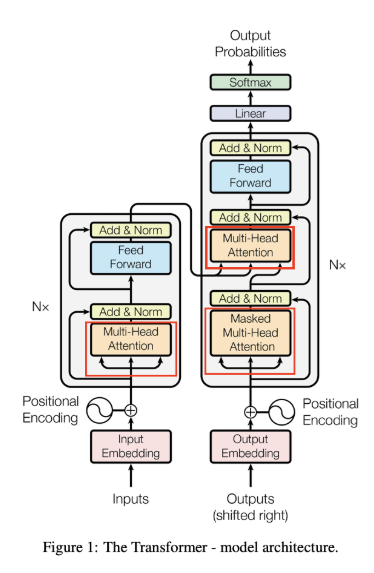

**Scaled Dot-Product Attention**

step1.准备Q、K、V:
    
* Q（Query）：通常是“查询”，可以是当前解码位置的隐藏向量，也可以是输入序列中某个位置的表示等，具体看任务以及所处的模块；用于在计算注意力分数时，衡量当前位置的词向量与其他位置词向量的相关性，就像是发出的 “询问”，来寻找与之匹配的信息

  $q_i=W^Qx_i$

* K（Key）：通常是将参考序列（可以是同一个序列或别的序列）的每个位置映射得到的键向量；可以理解为被查询对象的 “索引”，用于和 Query 计算相似度，判断哪些信息是 Query 需要重点关注的

  $k_i=W^Kk_i$

* V（Value）：与K相对应，每个位置的值向量，表示该位置需要传递给Query的信息；包含了实际要被提取和聚合的信息。在确定了 Query 和各个 Key 的相似度后，就会根据这些相似度对 Value 进行加权求和，从而得到注意力机制的输出

  $v_i=W^Vv_i$


step2.计算注意力得分：
    
1. 计算相似度

  对于每个 Query，将其与所有的 Key 进行点积运算，得到 Query 和每个 Key 的相似度分数。比如 Query $q_i$ 与所有 Key 的点积结果为

  $score(Q,K_i)=Q⋅K_i$

2. 缩放

  为了防止点积结果过大导致 Softmax 函数梯度消失，减缓梯度问题，会将点积结果除以 $\sqrt{d_{k}}$

  $\text{score}(Q, K_i) = \frac{Q \cdot K_i}{\sqrt{d_k}}$

    * 数值稳定：当向量维度较大时，QK的值分布会很大，导致softmax进入极端饱和区域，引发梯度消失或梯度爆炸
    * 控制范围：通过该方法，可以让注意力保持在一个比较合理的数值范围内，是的学习过程更加的平稳

3. softmax获得注意力权重

  对缩放后的分数使用 Softmax 函数进行归一化，得到注意力权重

  $\alpha_i=softmax(score(Q,K))$

  这样就得到了一组归一化系数$α_i$，表示对参考序列K各个位置的关注度

4. 加权求和

  根据注意力权重对所有的 Value 进行加权求和，得到最终的注意力输出
    $Attention(Q,K,V)=\sum_{i}α_i⋅V_i$




### **Self-Attention v.s. Cross-Attention**

  1. Self-Attention

    * 在一个序列的内部建模各个位置之间的依赖关系
    * 让网络可以捕捉到序列内部任意两位置之间的直接交互，无需循环地逐步传播消息


  2. Cross-Attention

    * Cross-Attention 用于计算两个不同序列之间的注意力，主要关注一个序列（通常称为“查询序列”）与另一个序列（通常称为“键值序列”）之间的关联

主流的Attention方法

1.  Scaled Dot-Product Attention
    
    * 由Q，K，V线性变换后做“点积+缩放+softmax+加权求和”

2.  Multi-Head Attention（MHA）

    * 将Q，K，V分为h个子空间（头），并行计算注意力，然后再concat起来再投影
    * 让模型在不同的子空间上学习到不同类型的关注模式，提升表现

3.  Relative Positional Encoding/Transformer-XL

4.  长序注意力变体

    * Transformer-XL、Longformer、BigBird等


**Attention 与全连接层区别**

* 全连接层只是一种线性或多层感知机（MLP）的变换，没有 “Query, Key, Value” 这一显式匹配过程；它对输入向量进行固定的、基于权重矩阵的线性（或带激活函数的非线性）映射，所有输入元素通过相同的权重矩阵进行变换，缺乏对序列中元素间动态关联的捕捉。

* Attention 则有对齐思想：用 Query 和 Key 的相似度来决定如何从 Value 中抽取信息。通过计算 Query 与各个 Key 的相似度得分，再基于得分对 Value 进行加权求和，能动态地关注序列中不同位置的重要信息。

* 因此 Attention 能够灵活地在序列中 “检索” 信息；而全连接只是对输入向量做固定映射，缺少这种 “可对比、可查询” 的交互。比如在处理文本时，Attention 可以根据当前词（Query）去 “查询” 文本中其他相关的词（Key），并从这些相关词的表示（Value）中抽取信息，从而更好地理解上下文，而全连接层无法做到这种针对特定元素的动态信息检索。

## ***不同类型的多头注意力：MHA、MQA、GQA***

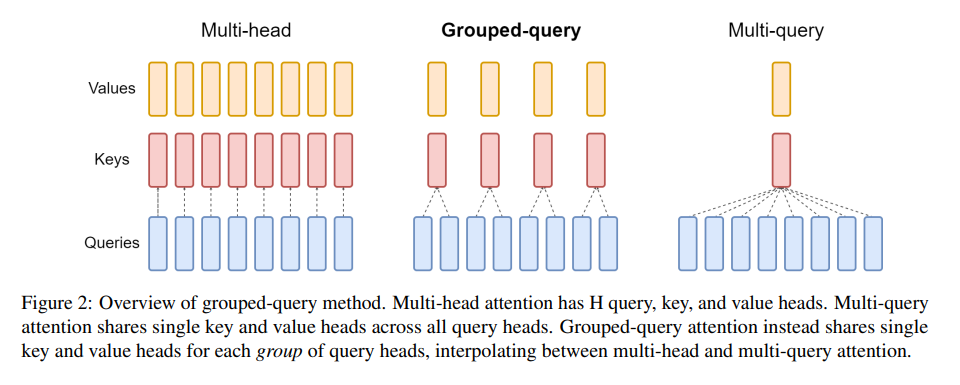

1.  MHA
  
        * 每个头有自己单独的key-value；h个Query、Key和Value矩阵

2.  MQA

        * 只有一组key-value对；
        * 即无论有多少个查询，都只用一组固定的键和值来计算注意力。这样大大减少了参数数量和计算量，因为不需要为每个头都生成独立的键和值向量
        * 显著降低了计算复杂度和内存占用，特别是在推理阶段，能大幅提升计算效率，加快模型的运行速度。在一些对推理速度要求较高的场景，如实时对话系统中非常适用
3.  GQA

        * 将Query分为N组，每个组共享一个Key和Value矩阵
        * 介于多头注意力和多查询注意力之间。与多头注意力相比，减少了键和值头的数量，同时又保留了一定的多头特性，不同组的查询可以关注到不同方面的信息
        * 既不损失太多性能，又可以利用MQA的推理加速

In [7]:
"""
  Multi-Head Attention (MHA)
"""

import torch
from torch import nn

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads   # 每个 head 的维度（必须整除）
        self.hidden_size = hidden_size

        # 初始化 Q、K、V 投影矩阵（维度保持不变）
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)

        # 输出线性层
        self.o_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden_state, attention_mask=None):
        """
        hidden_state: (batch_size, seq_len, hidden_size)
        """
        batch_size = hidden_state.size(0)
        print("输入 hidden_state:", hidden_state.shape)

        # Step 1: 线性投影
        # (batch_size, seq_len, hidden_size)
        query = self.q_linear(hidden_state)   # (B, S, H)
        key   = self.k_linear(hidden_state)   # (B, S, H)
        value = self.v_linear(hidden_state)   # (B, S, H)
        print("Q/K/V 投影后:", query.shape)

        # Step 2: 拆分多头
        # (B, S, H) → (B, num_heads, S, head_dim)
        query = self.split_head(query)
        key   = self.split_head(key)
        value = self.split_head(value)
        print("分头后 query:", query.shape)

        # Step 3: 计算注意力分数
        # query: (B, num_heads, S, head_dim)
        # key.transpose(-1,-2): (B, num_heads, head_dim, S)
        # 结果: (B, num_heads, S, S)
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) \
                           / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        print("注意力得分:", attention_scores.shape)

        # Step 4: 掩码
        if attention_mask is not None:
            # attention_mask: (B, 1, 1, S)，广播到 (B, num_heads, S, S)
            attention_scores += (1 - attention_mask) * -1e9

        # Step 5: softmax 归一化
        # (B, num_heads, S, S)，在最后一维归一化，每一行是一个 query 对所有 key 的分布
        attention_probs = torch.softmax(attention_scores, dim=-1)
        print("注意力权重:", attention_probs.shape)

        # Step 6: 加权求和
        # attention_probs: (B, num_heads, S, S)
        # value: (B, num_heads, S, head_dim)
        # 结果: (B, num_heads, S, head_dim)
        output = torch.matmul(attention_probs, value)
        print("加权后输出:", output.shape)

        # Step 7: 拼接多头
        # (B, num_heads, S, head_dim) → 先转置 → (B, S, num_heads, head_dim)
        # 再展平 → (B, S, H)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        print("合并头后输出:", output.shape)

        # Step 8: 线性层输出
        # (B, S, H)
        output = self.o_linear(output)
        print("线性层后输出:", output.shape)

        return output

    def split_head(self, x):
        """
        输入: (batch_size, seq_len, hidden_size)
        输出: (batch_size, num_heads, seq_len, head_dim)
        """
        batch_size, seq_len, _ = x.size()
        # (B, S, H) → (B, S, num_heads, head_dim)
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # (B, S, num_heads, head_dim) → (B, num_heads, S, head_dim)
        return x.transpose(1, 2)

In [8]:
torch.manual_seed(42)
batch_size, seq_len, hidden_size, num_heads = 2, 4, 8, 2
x = torch.randn(batch_size, seq_len, hidden_size)

mha = MultiHeadAttention(hidden_size, num_heads)
out = mha(x)

print("最终输出:", out.shape)

输入 hidden_state: torch.Size([2, 4, 8])
Q/K/V 投影后: torch.Size([2, 4, 8])
分头后 query: torch.Size([2, 2, 4, 4])
注意力得分: torch.Size([2, 2, 4, 4])
注意力权重: torch.Size([2, 2, 4, 4])
加权后输出: torch.Size([2, 2, 4, 4])
合并头后输出: torch.Size([2, 4, 8])
线性层后输出: torch.Size([2, 4, 8])
最终输出: torch.Size([2, 4, 8])


In [4]:
import torch
from torch import nn
import torch.nn.functional as F

x = torch.tensor([[1.0, 2.0, 3.0],
          [2.0, 4.0, 6.0]])
print(x.size())
x_probs_1 = torch.softmax(x, dim=-1)
print(x_probs_1)
x_probs_2 = torch.softmax(x, dim=-2)
print(x_probs_2)

torch.Size([2, 3])
tensor([[0.0900, 0.2447, 0.6652],
        [0.0159, 0.1173, 0.8668]])
tensor([[0.2689, 0.1192, 0.0474],
        [0.7311, 0.8808, 0.9526]])
